In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Functions

In [65]:
def fill_nulls(var, grouping_var):
    '''
    dataset : full data_frame
    var: variable in which nans need to be filled
    grouping_var : grouping variable used to determine best value to fill
    '''  
    import random
    import math
    
    # group vars
    grouped_df = pd.crosstab(index=grouping_var, columns=var,margins=True,normalize='index').round(3)
    
    # establish values to fill nulls with and groups to use
    values = list(grouped_df.columns)
    groups = list(grouped_df.index)
    groups.remove('All')
    
    # access each group one at a time and replace nulls there
    for group in groups:
        probabilities = grouped_df.loc[group, :].values
        
        # find indexes within that group that are nulls
        mask = ((grouping_var==group) & (var.isna()))
        nan_indexes = list(var[mask].index)
        random.shuffle(nan_indexes)
        
        # calculate the number of observations that match the corresponding percentage of values
        # for instance: if the percentage of 18-25 year olds that earl above $75k is 0.2, how many 
        # observations that have null values is that?
        
        lengths = [math.ceil(round(p,2)*len(nan_indexes)) for p in probabilities]
        
        # begin replacements
        for i in range(len(lengths)):
            sample = var[mask].sample(n=lengths[i])
            nulls_to_fill = list(sample.index)
            var.loc[nulls_to_fill] = values[i]
            proba = list(probabilities)
            maxprob_val = values[proba.index(max(proba))]
        var[mask] = maxprob_val
    return var

In [66]:
def visualize(df, var):
    num_nulls = df[var].isnull().sum() # count number ofnulls

    # copy data to variable that can be modified without modifying original dataframe
    var_data = df[[var, 'h1n1_vaccine', 'seasonal_vaccine']].copy() 

    # replace nulls with appropriate value
    var_data[var].fillna('no_response', inplace=True)

    # visualize results
    var_data.groupby(var)[['h1n1_vaccine', 'seasonal_vaccine']].mean().plot(kind='bar')
    plt.title(f'{var} : nulls = {num_nulls}');

In [67]:
def null_replacement(data, var):
    visualize(data, var)
    print(f'Number of Nulls: {data[var].isna().sum()},\n Value Counts : {data[var].value_counts()}')

## Import data

In [68]:
features = pd.read_csv('../training_set_features.csv')
labels = pd.read_csv('../training_set_labels.csv')

In [69]:
features.shape

(26707, 36)

In [70]:
data = pd.merge(left=features, right=labels, on='respondent_id')

In [71]:
data.isna().sum()

respondent_id                      0
h1n1_concern                      92
h1n1_knowledge                   116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_h1n1_vacc_effective      391
opinion_h1n1_risk                388
opinion_h1n1_sick_from_vacc      395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4423
m

In [72]:
data['age_group'].value_counts()

65+ Years        6843
55 - 64 Years    5563
45 - 54 Years    5238
18 - 34 Years    5215
35 - 44 Years    3848
Name: age_group, dtype: int64

#### **Print out the percentage of nulls that belong to the positive class of each target variable**

**for instance:**

```
h1n1_concern    
h1n1_vaccine        0.173913    
seasonal_vaccine    0.456522  
dtype: float64  
Nulls : 92  
```
**means:**
The variable `h1n1_concern` has 92 null values. 17% of these nulls are in the positive class for `h1h1_vaccine` and the rest in teh negative class. 45% of the 92 nulls are in the positive class for `seasonal_vaccine` and the rest belong to the negative class. 

This is just to check if there are any null values that are more likely to belong to one class versus the other which will help us determine how we should replace them. 


In [73]:
column = []
h1n1 = []
sea = []
nulls = []

for col in list(data.columns):
    if data[col].isna().sum() > 0:
        column.append(col)
        h1n1.append(data[data[col].isnull()][['h1n1_vaccine', 'seasonal_vaccine']].mean()['h1n1_vaccine']) 
        sea.append(data[data[col].isnull()][['h1n1_vaccine', 'seasonal_vaccine']].mean()['seasonal_vaccine'])
        nulls.append(data[col].isna().sum())
        # print(col)
        # print(data[data[col].isnull()][['h1n1_vaccine', 'seasonal_vaccine']].mean())
        # print(f'Nulls : {data[col].isna().sum()}')
        # print('--------------------------\n--------------------------')
        
null_df = pd.DataFrame({'column' : column, 'h1n1': h1n1, 'seasonal' : sea, 'nulls' : nulls})
null_df.sort_values('nulls', ascending=False)

,column,h1n1,seasonal,nulls
29,employment_occupation,0.208909,0.508389,13470
28,employment_industry,0.207877,0.508102,13330
14,health_insurance,0.112759,0.424149,12274
22,income_poverty,0.189012,0.448338,4423
9,doctor_recc_h1n1,0.085648,0.352315,2160
10,doctor_recc_seasonal,0.085648,0.352315,2160
24,rent_or_own,0.193928,0.419197,2042
25,employment_status,0.185236,0.387560,1463
23,marital_status,0.181818,0.389205,1408
21,education,0.185501,0.385217,1407


#### Doing some EDA and replacing nulls. Nulls will be replaced proportionally with respect to a grouping variable if there are more than 5% of observations with null values (i.e, 1000). Otherwise we will fill with median/mode value

#### Sean's features

Number of Nulls: 92,
 Value Counts : 2.0    10575
1.0     8153
3.0     4591
0.0     3296
Name: h1n1_concern, dtype: int64


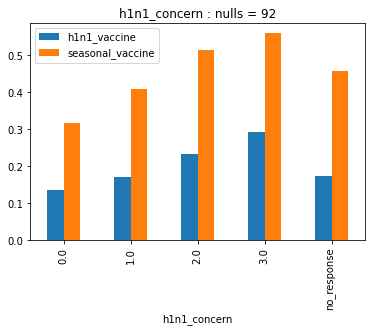

In [74]:
var = 'h1n1_concern'
null_replacement(data, var)

In [75]:
data[var].isna().sum()

92

In [76]:
data['income_poverty'].value_counts()

<= $75,000, Above Poverty    12777
> $75,000                     6810
Below Poverty                 2697
Name: income_poverty, dtype: int64

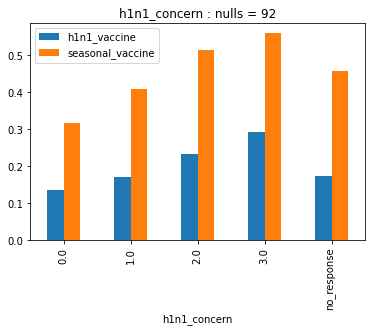

In [77]:
visualize(data, 'h1n1_concern')

In [78]:
data['h1n1_concern'].value_counts()

2.0    10575
1.0     8153
3.0     4591
0.0     3296
Name: h1n1_concern, dtype: int64

In [79]:
## replacing this with mode = 2.0

data['h1n1_concern'].fillna(2.0, inplace=True)
data['h1n1_concern'].isna().sum()

0

Number of Nulls: 116,
 Value Counts : 1.0    14598
2.0     9487
0.0     2506
Name: h1n1_knowledge, dtype: int64


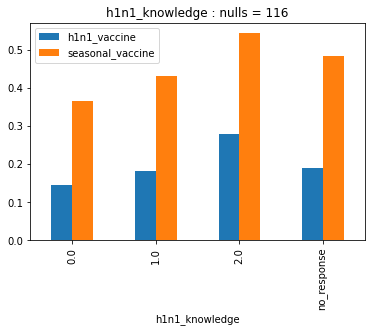

In [80]:
null_replacement(data, 'h1n1_knowledge')

In [81]:
data['h1n1_knowledge'].value_counts()

1.0    14598
2.0     9487
0.0     2506
Name: h1n1_knowledge, dtype: int64

In [82]:
## replacing this with mode = 1.0

data['h1n1_knowledge'].fillna(1.0, inplace=True)
data['h1n1_knowledge'].isna().sum()

0

Number of Nulls: 71,
 Value Counts : 0.0    25335
1.0     1301
Name: behavioral_antiviral_meds, dtype: int64


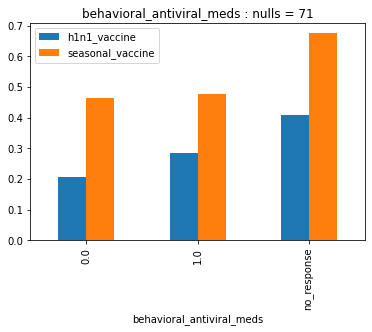

In [83]:
null_replacement(data, 'behavioral_antiviral_meds')

In [84]:
# fill with 0.0
data['behavioral_antiviral_meds'].fillna(0.0, inplace=True)
data['behavioral_antiviral_meds'].isna().sum()

0

Number of Nulls: 208,
 Value Counts : 1.0    19228
0.0     7271
Name: behavioral_avoidance, dtype: int64


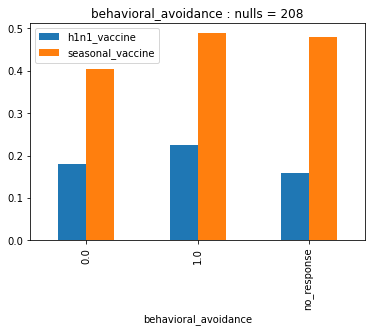

In [85]:
null_replacement(data, 'behavioral_avoidance')

In [86]:
data['behavioral_avoidance'].isna().sum()

208

In [87]:
data['behavioral_avoidance'].value_counts()

1.0    19228
0.0     7271
Name: behavioral_avoidance, dtype: int64

In [88]:
data['behavioral_avoidance'].fillna(1.0, inplace=True)
data['behavioral_avoidance'].isna().sum()

0

Number of Nulls: 19,
 Value Counts : 0.0    24847
1.0     1841
Name: behavioral_face_mask, dtype: int64


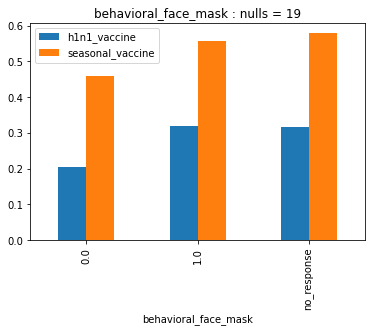

In [89]:
null_replacement(data, 'behavioral_face_mask')

In [90]:
data['behavioral_face_mask'].fillna(0, inplace=True)
data['behavioral_face_mask'].isna().sum()

0

Number of Nulls: 42,
 Value Counts : 1.0    22015
0.0     4650
Name: behavioral_wash_hands, dtype: int64


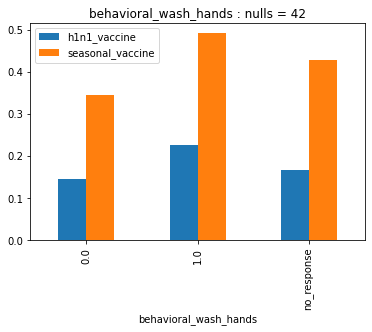

In [91]:
null_replacement(data, 'behavioral_wash_hands')

In [92]:
data['behavioral_wash_hands'].fillna(1.0, inplace=True)

In [93]:
data['behavioral_wash_hands'].isna().sum()

0

Number of Nulls: 87,
 Value Counts : 0.0    17073
1.0     9547
Name: behavioral_large_gatherings, dtype: int64


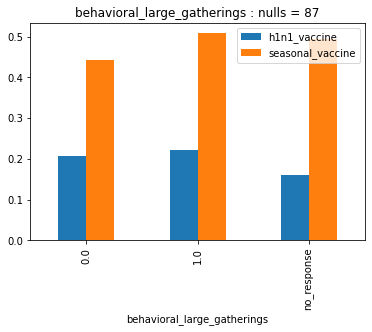

In [94]:
null_replacement(data, 'behavioral_large_gatherings')

In [95]:
data['behavioral_large_gatherings'].fillna(0, inplace=True)
data['behavioral_large_gatherings'].isna().sum()

0

In [96]:
data.columns

Index(['respondent_id', 'h1n1_concern', 'h1n1_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation', 'h1n1_vaccine', 'seasonal_vaccine'],
      dtype='object')

Number of Nulls: 82,
 Value Counts : 0.0    17644
1.0     8981
Name: behavioral_outside_home, dtype: int64


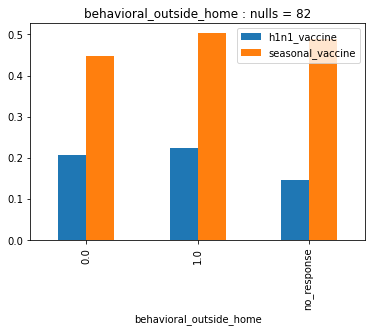

In [97]:
null_replacement(data, 'behavioral_outside_home')

In [98]:
data['behavioral_outside_home'].fillna(0, inplace=True)
data['behavioral_outside_home'].isna().sum()

0

Number of Nulls: 128,
 Value Counts : 1.0    18001
0.0     8578
Name: behavioral_touch_face, dtype: int64


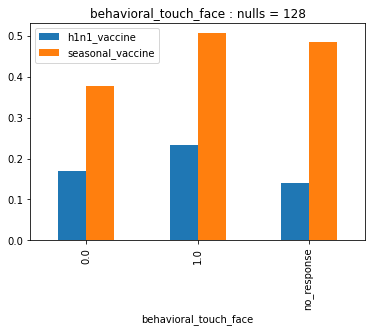

In [99]:
null_replacement(data, 'behavioral_touch_face')

In [100]:
data['behavioral_touch_face'].fillna(1, inplace=True)
data['behavioral_touch_face'].isna().sum()

0

Number of Nulls: 2160,
 Value Counts : 0.0    19139
1.0     5408
Name: doctor_recc_h1n1, dtype: int64


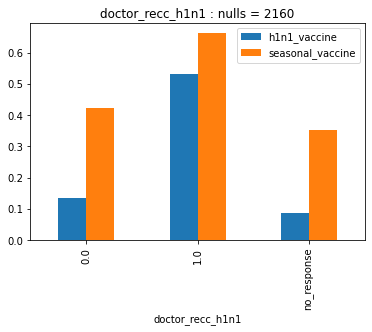

In [101]:
null_replacement(data, 'doctor_recc_h1n1')

In [102]:
# since there are a lot of nulls, we will be creating a no_response category to replace all the nulls
data['doctor_recc_h1n1'].fillna('no_response', inplace=True)
data['doctor_recc_h1n1'].isna().sum()

0

Number of Nulls: 2160,
 Value Counts : 0.0    16453
1.0     8094
Name: doctor_recc_seasonal, dtype: int64


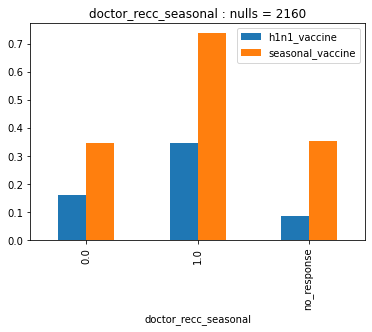

In [103]:
null_replacement(data, 'doctor_recc_seasonal')

In [104]:
# since there are a lot of nulls, we will be creating a no_response category to replace all the nulls
data['doctor_recc_seasonal'].fillna('no_response', inplace=True)
data['doctor_recc_seasonal'].isna().sum()

0

Number of Nulls: 971,
 Value Counts : 0.0    18446
1.0     7290
Name: chronic_med_condition, dtype: int64


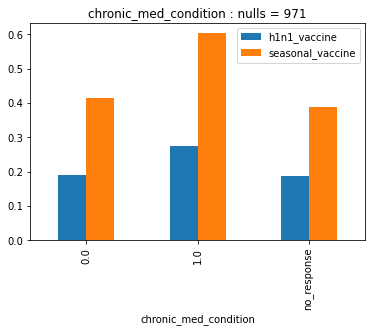

In [105]:
null_replacement(data, 'chronic_med_condition')

In [106]:
# since there are a lot of nulls, we will be creating a no_response category to replace all the nulls
data['chronic_med_condition'].fillna('no_response', inplace=True)
data['chronic_med_condition'].isna().sum()

0

#### Kartin's features

In [107]:
#'opinion_h1n1_vacc_effective' - There are 391 null values. The median is 4. Replace missing values with 4. 
data['opinion_h1n1_vacc_effective'].fillna(4, inplace = True)
#'opinion_h1n1_risk' There are 388 null values. The median is 2. Replace missing values with 2. 
data['opinion_h1n1_risk'].fillna(2, inplace = True)
#'opinion_h1n1_sick_from_vacc' There are 395 nulls values. The median is 2. Replace missing values with 2. 
data['opinion_h1n1_sick_from_vacc'].fillna(2, inplace = True)
# 'opinion_seas_vacc_effective'There are 462 null values.  The median is 4. Replace missing values with 4. 
data['opinion_seas_vacc_effective'].fillna(2, inplace = True)
#'opinion_seas_risk' There are 514 null values. The median is 2. Replace missing values with 2. 
data['opinion_seas_risk'].fillna(2, inplace = True)
# 'opinion_seas_sick_from_vacc' There are 537 null values. The median is 2. Replace missing values with 2. 
data['opinion_seas_sick_from_vacc'].fillna(2, inplace = True)

Number of Nulls: 820,
 Value Counts : 0.0    23749
1.0     2138
Name: child_under_6_months, dtype: int64


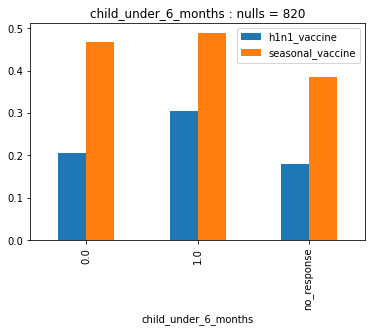

In [108]:
null_replacement(data, 'child_under_6_months')

In [109]:
pd.crosstab(index=data['age_group'], columns=data['child_under_6_months'],margins=True,normalize='index').round(3)

child_under_6_months,0.0,1.0
age_group,,
18 - 34 Years,0.865,0.135
35 - 44 Years,0.910,0.090
45 - 54 Years,0.924,0.076
55 - 64 Years,0.922,0.078
65+ Years,0.953,0.047
All,0.917,0.083


In [110]:
pd.crosstab(index=data['age_group'], columns=data['child_under_6_months'].fillna('no_response'),margins=True,normalize='index').round(3)

child_under_6_months,0.0,1.0,no_response
age_group,,,
18 - 34 Years,0.831,0.130,0.039
35 - 44 Years,0.873,0.087,0.040
45 - 54 Years,0.898,0.074,0.028
55 - 64 Years,0.901,0.076,0.023
65+ Years,0.927,0.046,0.027
All,0.889,0.080,0.031


In [111]:
data['child_under_6_months'] = fill_nulls(var=data['child_under_6_months'], grouping_var=data['age_group'])

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\LAVANY~1\AppData\Local\Temp/ipykernel_18096/247782949.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  var[mask] = maxprob_val


In [112]:
test_data.value_counts()

NameError: name 'test_data' is not defined

In [113]:
pd.crosstab(index=data['age_group'], columns=test_data.fillna('no_response'),margins=True,normalize='index').round(3)

NameError: name 'test_data' is not defined

In [114]:
data[data['child_under_6_months'].isna()]['child_under_6_months'].head(20)

Series([], Name: child_under_6_months, dtype: float64)

In [115]:
test_data[183]

NameError: name 'test_data' is not defined

Number of Nulls: 12274,
 Value Counts : 1.0    12697
0.0     1736
Name: health_insurance, dtype: int64


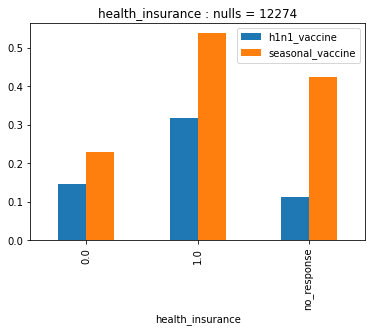

In [116]:
null_replacement(data, 'health_insurance')

Number of Nulls: 0,
 Value Counts : yes            12697
no_response    12274
no              1736
Name: health_insurance, dtype: int64


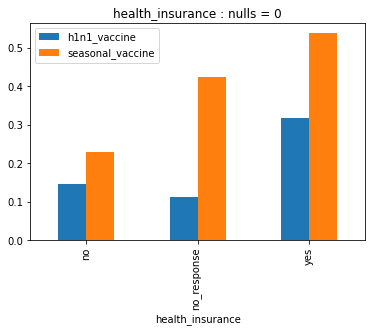

In [117]:
data['health_insurance'].fillna('no_response', inplace=True)
data['health_insurance'].replace({0 : 'no', 1 : 'yes'}, inplace=True)
null_replacement(data, 'health_insurance')

Number of Nulls: 804,
 Value Counts : 0.0    23004
1.0     2899
Name: health_worker, dtype: int64


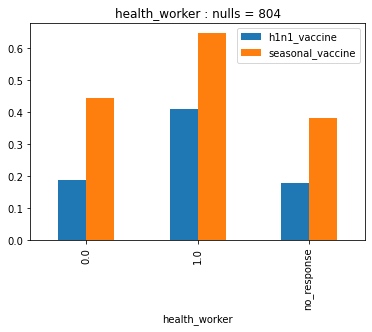

In [118]:
null_replacement(data, 'health_worker')

Number of Nulls: 0,
 Value Counts : no             23004
yes             2899
no_response      804
Name: health_worker, dtype: int64


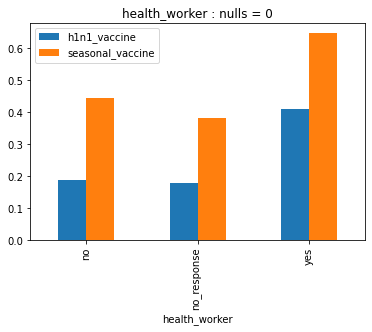

In [119]:
data['health_worker'].fillna('no_response', inplace=True)
data['health_worker'].replace({0 : 'no', 1 : 'yes'}, inplace=True)
null_replacement(data, 'health_worker')

Number of Nulls: 1407,
 Value Counts : College Graduate    10097
Some College         7043
12 Years             5797
< 12 Years           2363
Name: education, dtype: int64


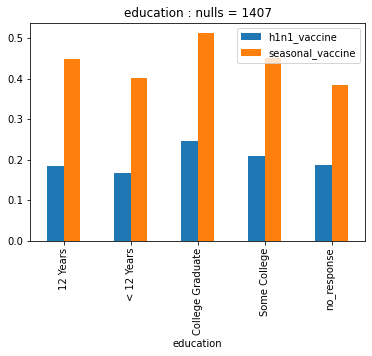

In [120]:
null_replacement(data, 'education')

In [121]:
pd.crosstab(index=data['age_group'], columns=data['education'],margins=True,normalize='index').round(4)*100

education,12 Years,< 12 Years,College Graduate,Some College
age_group,,,,
18 - 34 Years,22.84,10.39,35.08,31.70
35 - 44 Years,16.58,7.08,50.00,26.34
45 - 54 Years,21.57,6.81,42.60,29.02
55 - 64 Years,21.47,7.20,44.54,26.79
65+ Years,28.60,13.47,32.18,25.76
All,22.91,9.34,39.91,27.84


In [122]:
data['education'].fillna('no_response', inplace=True)

In [123]:
data['education'].isna().sum()

0

### EDA for each variable
**I will be plotting observation counts/percentages for each category in the column as well as for the nulls and replacing null values based on what I see**

In [237]:
def replace(var, kind, grouping_var='', dataset=[]):
    '''
    replace the null values with either 'no_response', or using percentages of distribution of values according to age group
    '''
    if kind=='no_response':
        return var_data[var].fillna('no_response', inplace=True)
    elif kind=='age_group':
        retdata = fill_nulls(dataset, var, grouping_var) 
        return retdata

In [246]:
pd.crosstab(index=data['age_group'], columns=data['income_poverty'],margins=True,normalize='index').round(3)

income_poverty,"<= $75,000, Above Poverty","> $75,000",Below Poverty
age_group,,,
18 - 34 Years,0.536,0.265,0.200
35 - 44 Years,0.454,0.432,0.114
45 - 54 Years,0.501,0.406,0.093
55 - 64 Years,0.579,0.338,0.083
65+ Years,0.736,0.145,0.118
All,0.573,0.306,0.121


In [242]:
test_data = fill_nulls(var='income_poverty', grouping_var='age_group', dataset=data)

C:\Users\LAVANY~1\AppData\Local\Temp/ipykernel_18880/2360538483.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[var][nulls_to_fill] = values[i]


In [247]:
pd.crosstab(index=test_data['age_group'], columns=test_data['income_poverty'].fillna('no_response'),margins=True,normalize='index').round(3)

income_poverty,"<= $75,000, Above Poverty","> $75,000",Below Poverty
age_group,,,
18 - 34 Years,0.536,0.265,0.200
35 - 44 Years,0.454,0.432,0.114
45 - 54 Years,0.501,0.406,0.093
55 - 64 Years,0.579,0.338,0.083
65+ Years,0.736,0.145,0.118
"<= $75,000, Above Poverty",1.000,0.000,0.000
All,0.644,0.255,0.101


In [124]:
data['income_poverty'].isna().sum()

4423

#### sex

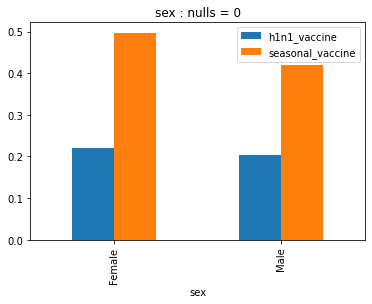

In [126]:
var = 'sex'

visualize(data, var)

#### income poverty

In [127]:
data['income_poverty'].isna().sum()

4423

In [128]:
data['income_poverty'].value_counts()

<= $75,000, Above Poverty    12777
> $75,000                     6810
Below Poverty                 2697
Name: income_poverty, dtype: int64

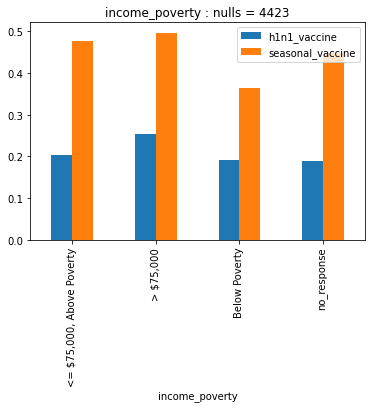

In [130]:
visualize(data, 'income_poverty')

In [131]:
data['income_poverty'].fillna('no_response', inplace=True)

### marital_status

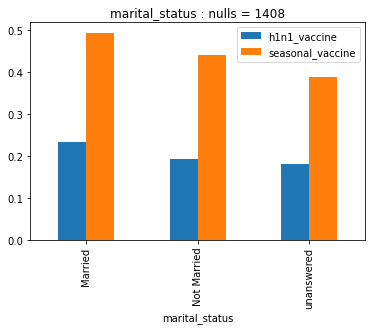

In [132]:
var = 'marital_status'

var_data = data[[var, 'h1n1_vaccine', 'seasonal_vaccine']].copy()
var_data[var].fillna('unanswered', inplace=True)
var_data.groupby(var)[['h1n1_vaccine', 'seasonal_vaccine']].mean().plot(kind='bar')
plt.title(f'{var} : nulls = {data[var].isnull().sum()}');

In [133]:
data['marital_status'].fillna('no_response', inplace=True)

**Replace nulls in `marital_status` by 'unasnwered'**

#### employment_occupation

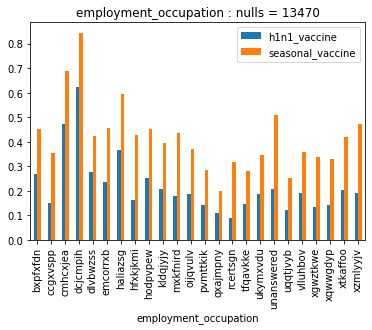

In [134]:
var = 'employment_occupation'

var_data = data[[var, 'h1n1_vaccine', 'seasonal_vaccine']].copy()
var_data[var].fillna('unanswered', inplace=True)

var_data.groupby(var)[['h1n1_vaccine', 'seasonal_vaccine']].mean().plot(kind='bar')
plt.title(f'{var} : nulls = {data[var].isnull().sum()}');

In [135]:
data['employment_occupation'].fillna('no_response', inplace=True)

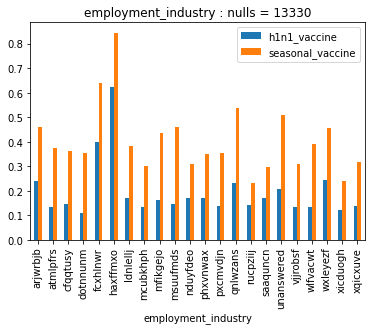

In [136]:
var = 'employment_industry'

var_data = data[[var, 'h1n1_vaccine', 'seasonal_vaccine']].copy()
var_data[var].fillna('unanswered', inplace=True)
var_data.groupby(var)[['h1n1_vaccine', 'seasonal_vaccine']].mean().plot(kind='bar')
plt.title(f'{var} : nulls = {data[var].isnull().sum()}');

In [137]:
data['employment_industry'].fillna('no_response', inplace=True)

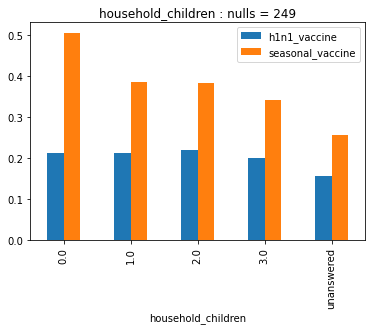

In [138]:
var = 'household_children'

var_data = data[[var, 'h1n1_vaccine', 'seasonal_vaccine']].copy()
var_data[var].fillna('unanswered', inplace=True)
var_data.groupby(var)[['h1n1_vaccine', 'seasonal_vaccine']].mean().plot(kind='bar')
plt.title(f'{var} : nulls = {data[var].isnull().sum()}');

In [139]:
pd.crosstab(index=data['age_group'], columns=data['household_children'],margins=True,normalize='index').round(4)*100

household_children,0.0,1.0,2.0,3.0
age_group,,,,
18 - 34 Years,50.60,19.33,17.64,12.43
35 - 44 Years,30.48,20.16,29.44,19.92
45 - 54 Years,63.33,18.17,13.42,5.08
55 - 64 Years,90.70,6.11,2.01,1.17
65+ Years,96.65,2.15,0.69,0.51
All,70.57,12.00,10.82,6.60


In [140]:
data['household_children'] = fill_nulls(data['household_children'], grouping_var=data['age_group'])

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\LAVANY~1\AppData\Local\Temp/ipykernel_18096/247782949.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  var[mask] = maxprob_val


In [141]:
pd.crosstab(index=data['age_group'], columns=data['household_children'],margins=True,normalize='index').round(4)*100

household_children,0.0,1.0,2.0,3.0
age_group,,,,
18 - 34 Years,51.83,18.85,17.20,12.12
35 - 44 Years,31.89,19.75,28.85,19.52
45 - 54 Years,63.59,18.04,13.33,5.04
55 - 64 Years,90.71,6.11,2.01,1.17
65+ Years,96.65,2.15,0.69,0.51
All,70.85,11.89,10.72,6.54


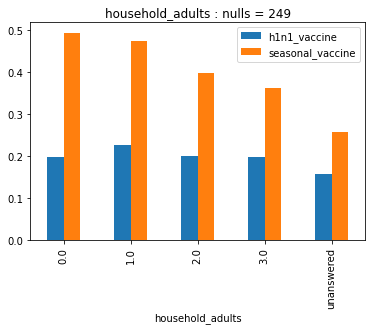

In [142]:
var = 'household_adults'

var_data = data[[var, 'h1n1_vaccine', 'seasonal_vaccine']].copy()
var_data[var].fillna('unanswered', inplace=True)
var_data.groupby(var)[['h1n1_vaccine', 'seasonal_vaccine']].mean().plot(kind='bar')
plt.title(f'{var} : nulls = {data[var].isnull().sum()}');

In [143]:
data['household_adults'] = fill_nulls(data['household_adults'], grouping_var=data['age_group'])

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\LAVANY~1\AppData\Local\Temp/ipykernel_18096/247782949.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  var[mask] = maxprob_val


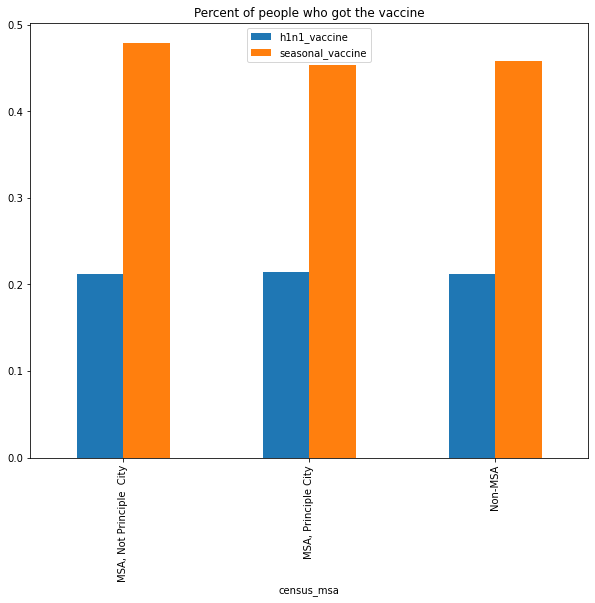

In [144]:
data.groupby('census_msa')[['h1n1_vaccine', 'seasonal_vaccine']].mean().plot(kind='bar', figsize=(10,8));
plt.title('Percent of people who got the vaccine');

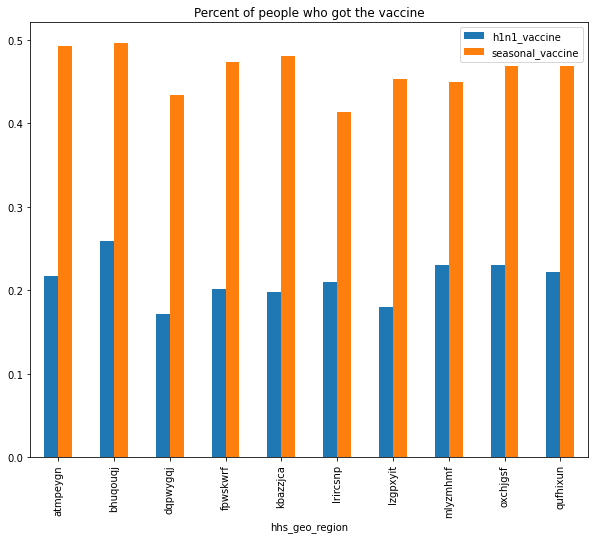

In [145]:
data.groupby('hhs_geo_region')[['h1n1_vaccine', 'seasonal_vaccine']].mean().plot(kind='bar', figsize=(10,8));
plt.title('Percent of people who got the vaccine');

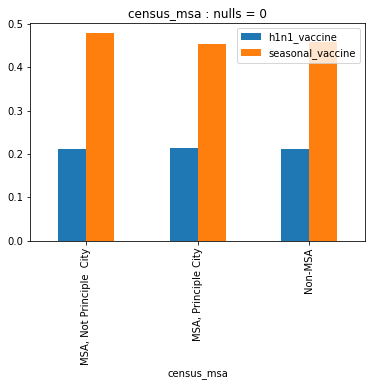

In [146]:
var = 'census_msa'

var_data = data[[var, 'h1n1_vaccine', 'seasonal_vaccine']].copy()
var_data[var].fillna('unanswered', inplace=True)
var_data.groupby(var)[['h1n1_vaccine', 'seasonal_vaccine']].mean().plot(kind='bar')
plt.title(f'{var} : nulls = {data[var].isnull().sum()}');

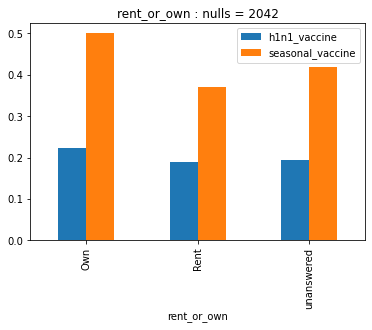

In [147]:
var = 'rent_or_own'

var_data = data[[var, 'h1n1_vaccine', 'seasonal_vaccine']].copy()
var_data[var].fillna('unanswered', inplace=True)
var_data.groupby(var)[['h1n1_vaccine', 'seasonal_vaccine']].mean().plot(kind='bar')
plt.title(f'{var} : nulls = {data[var].isnull().sum()}');

In [148]:
data['rent_or_own'].fillna('no_response', inplace=True)

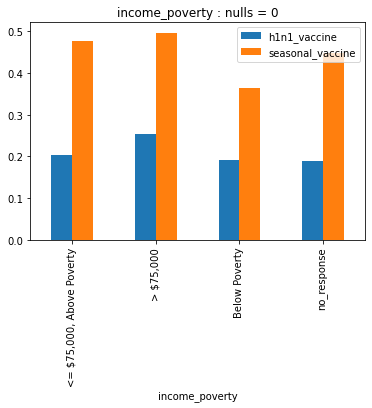

In [149]:
var = 'income_poverty'

var_data = data[[var, 'h1n1_vaccine', 'seasonal_vaccine']].copy()
var_data[var].fillna('unanswered', inplace=True)
var_data.groupby(var)[['h1n1_vaccine', 'seasonal_vaccine']].mean().plot(kind='bar')
plt.title(f'{var} : nulls = {data[var].isnull().sum()}');

In [154]:
data['employment_status'].isna().sum()

1463

In [152]:
data['employment_status'].value_counts()

Employed              13560
Not in Labor Force    10231
Unemployed             1453
Name: employment_status, dtype: int64

In [153]:
pd.crosstab(index=data['age_group'], columns=data['employment_status'],margins=True,normalize='index').round(4)*100

employment_status,Employed,Not in Labor Force,Unemployed
age_group,,,
18 - 34 Years,62.37,28.67,8.96
35 - 44 Years,76.68,16.87,6.44
45 - 54 Years,74.98,17.50,7.52
55 - 64 Years,57.99,36.12,5.89
65+ Years,15.45,82.95,1.60
All,53.72,40.53,5.76


In [155]:
data['employment_status'].fillna('no_response', inplace=True)

In [156]:
data.isna().sum()

respondent_id                  0
h1n1_concern                   0
h1n1_knowledge                 0
behavioral_antiviral_meds      0
behavioral_avoidance           0
behavioral_face_mask           0
behavioral_wash_hands          0
behavioral_large_gatherings    0
behavioral_outside_home        0
behavioral_touch_face          0
doctor_recc_h1n1               0
doctor_recc_seasonal           0
chronic_med_condition          0
child_under_6_months           0
health_worker                  0
health_insurance               0
opinion_h1n1_vacc_effective    0
opinion_h1n1_risk              0
opinion_h1n1_sick_from_vacc    0
opinion_seas_vacc_effective    0
opinion_seas_risk              0
opinion_seas_sick_from_vacc    0
age_group                      0
education                      0
race                           0
sex                            0
income_poverty                 0
marital_status                 0
rent_or_own                    0
employment_status              0
hhs_geo_re

In [158]:
data.to_csv('../train_clean.csv', index=False)

# checking nulls

In [ ]:
data.isnull().sum()

In [ ]:
col='income_poverty'
data[data[col].isnull()][['h1n1_vaccine', 'seasonal_vaccine']].mean()

#### on average, about 80% of null values are participants who did not get the h1n1 vaccine. And 20% are those that did. This is the same as the baseline percentage of people who got the H1N1 vaccine

In [ ]:
for col in list(data.columns):
    if data[col].isna().sum() > 0:
        print(col)
        print(data[data[col].isnull()][['h1n1_vaccine', 'seasonal_vaccine']].mean())
        print(f'Nulls : {data[col].isna().sum()}')
        print('--------------------------\n--------------------------')

In [ ]:
data[data['household_adults']==0][['household_children']].value_counts()

In [ ]:
# I think we need to replace 0 household adults with 1. 

In [ ]:
# people who did not answer adults also did not answer about children
data[data['household_adults'].isna()][['household_children']]

In [ ]:
data[data['household_adults'].isna()].isna().sum()

In [ ]:
var = 'health_insurance'

var_data = df[[var, 'h1n1_vaccine', 'seasonal_vaccine']].copy()
var_data[var].fillna('unanswered', inplace=True)
var_data.groupby(var)[['h1n1_vaccine', 'seasonal_vaccine']].mean().plot(kind='bar')
plt.title(f'{var} : nulls = {df[var].isnull().sum()}');

In [ ]:
var = 'opinion_h1n1_vacc_effective'

var_data = df[[var, 'h1n1_vaccine', 'seasonal_vaccine']].copy()
var_data[var].fillna('unanswered', inplace=True)
var_data.groupby(var)[['h1n1_vaccine', 'seasonal_vaccine']].mean().plot(kind='bar')
plt.title(f'{var} : nulls = {df[var].isnull().sum()}');

In [ ]:
df['chronic_med_condition'].fillna('unanswered', inplace=True)

In [ ]:
pd.crosstab(index=df['age_group'], columns=df['chronic_med_condition'],margins=True,normalize='index').round(4)*100